<a href="https://colab.research.google.com/github/koliche/Arabic-Text-Classification/blob/main/Arabic_Text_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect the lab to My Drive**

In [3]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount=True)

In [2]:
cd /content/gdrive/MyDrive/TextClassification

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/TextClassification'
/content


# **Load The Dataset**

In [ ]:
!unzip Khaleej.zip -d /content/Khaleej/
# !unzip sanad_dataset.zip -d /content/gdrive/MyDrive/TextClassification/sanad_dataset

In [ ]:
import os
import tensorflow as tf
import numpy as np


In [ ]:
raw_data = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/Khaleej',
    labels = "inferred",
    label_mode = "int",
    max_length = None,
    shuffle=True,
    seed=32,
    validation_split=None,
    subset=None,
)

Found 45500 files belonging to 7 classes.


In [ ]:
raw_data.class_names

['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']

In [ ]:
# text_batch_array = np.array([s.numpy() for text_batch, label_batch in raw_data for s in text_batch])
# text_batch_decoded = np.vectorize(lambda s: s.decode("utf-8"))(text_batch_array)
# x = text_batch_decoded.tolist()

# label_batch_array = np.array([label for text_batch, label_batch in raw_data for label in label_batch])
# y = [raw_data.class_names[label] for label in label_batch_array]

# print(len(x))
# print(len(y))

In [ ]:
x=[]
y=[]
for text_batch, label_batch in raw_data:
    for i in range(len(text_batch)):
        s=text_batch.numpy()[i].decode("utf-8") 
        x.append(s)
        y.append(raw_data.class_names[label_batch.numpy()[i]])
print(len(x))
print(len(y))

45500
45500


In [ ]:
# x[:] , y[:]

# **Data Visualization**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 


In [ ]:
data =pd.DataFrame({"text":x,"label":y})

In [ ]:
data.shape

(45500, 2)

In [ ]:
data.head()

,text,label
0,اقترب سلتيك مجدداً من غريمه التقليدي رينجرز ال...,Sports
1,‮«‬الدين المعاملة‮» ‬هكذا علمنا رسول الله‮- ‬ص...,Religion
2,صعق أوكلاهوما سيتي ثاندر منافسه غولدن ستايت وو...,Sports
3,استقبل الوسط المسرحي الإماراتي فوز الإمارات بر...,Culture
4,الشارقة: «الخليج» أطلقت دائرة التخطيط والمساحة...,Tech


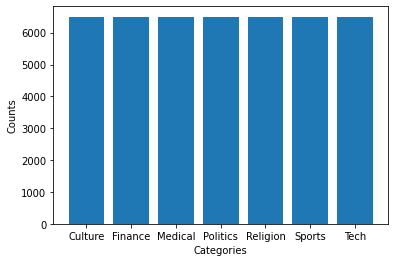

In [ ]:
#visualize the distribution of dataset 
unique, counts = np.unique(data['label'], return_counts=True)
plt.bar(unique, counts, align='center')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

In [ ]:
data.describe()

,text,label
count,45500,45500
unique,45485,7
top,إعداد: محمد صالح القرق دخل على رسول الله- صلى ...,Sports
freq,3,6500


# **Data Pre-Processing**

# **Data Cleaning**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def removeEmoji(dataset_text_row):
    #Remove Emoji Exemple code :
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    # this is out of jupyter memorry !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    result = emoji_pattern.sub(r'',dataset_text_row)
    return result

def removeDiacritics(dataset_text_row):
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    result = re.sub(arabic_diacritics, '', dataset_text_row)
    return result

def removeSpecialChar(dataset_text_row):
    # With space "[^\w]+|_"
    # Without space "[^\w\s]+|_"
    special_charachers = "[^\w\s]+|_"
    result = re.sub(special_charachers, '', dataset_text_row, flags=re.U)
    return result

def removeStopwords(dataset_text_row):
  stop_words = set(stopwords.words('arabic'))
  words = dataset_text_row.split()
  result = [word for word in words if not word in stop_words]
  return result

In [ ]:
data['cleaned_text'] = data['text'].apply(removeEmoji)
data['cleaned_text'] = data['cleaned_text'].apply(removeDiacritics)
data['cleaned_text'] = data['cleaned_text'].apply(removeSpecialChar)
data['cleaned_text'] = data['cleaned_text'].apply(removeStopwords)
print(data['cleaned_text'].head(80))

0     [قتل, 8, عسكريين, جزائريين, وأصيب, 8, بجروح, ا...
1     [افتتح, عبدالله, سعيد, بن, سويف, سكرتير, إدارة...
2     [كشف, سوميت, نيهالاني, مدير, المبيعات, مؤشرات,...
3     [أبوظبيمحمد, علاونة, تحتاج, الثقافة, العربية, ...
4     [ضمن, الفعاليات, الشعرية, المعرض, قرأت, الشاعر...
                            ...                        
75    [وقعت, وزارة, التربية, والتعليم, هامش, معرض, ج...
76    [يسعى, مدريد, حامل, اللقب, تكريس, عقدته, القار...
77    [مازالت, تداعيات, قيام, الكويتيين, عبد, الله, ...
78    [وقعت, مؤسسة, دبي, لخدمات, الإسعاف, اتفاقية, ت...
79    [فاسألوا, أهل, الذكر, كنتم, تعلمون, صدق, الله,...
Name: cleaned_text, Length: 80, dtype: object


In [ ]:
data['text'].head(80)

0     اقترب سلتيك مجدداً من غريمه التقليدي رينجرز ال...
1     ‮«‬الدين المعاملة‮» ‬هكذا علمنا رسول الله‮- ‬ص...
2     صعق أوكلاهوما سيتي ثاندر منافسه غولدن ستايت وو...
3     استقبل الوسط المسرحي الإماراتي فوز الإمارات بر...
4     الشارقة: «الخليج» أطلقت دائرة التخطيط والمساحة...
                            ...                        
75    أطلقت وزارة الصحة تطبيقات ال iPhone كمبادرة جد...
76    صادقت سلطات الاحتلال على إضافة وحدات استيطانية...
77    أبوظبي «الخليج»: ارتفع مؤشر سوق الإمارات المال...
78    أكد الاتحاد البرلماني الدولي أن القرار الذي ات...
79    سجل راوول الونسو خيمينز هدفاً خارقاً من كرة أك...
Name: text, Length: 80, dtype: object

## **Tokenization**

In [ ]:
def tokenization(dataset_text_row):
    tokens = word_tokenize(dataset_text_row)
    return tokens

In [ ]:
data['tokens'] = data['text'].apply(tokenization)
print(data['tokens'].head(80))

0     [قتل, 8, عسكريين, جزائريين, وأصيب, 8, بجروح،, ...
1     [افتتح, عبدالله, سعيد, بن, سويف, سكرتير, إدارة...
2     [كشف, سوميت, نيهالاني, مدير, المبيعات, في, مؤش...
3     [أبوظبي, :, محمد, علاونة, تحتاج, الثقافة, العر...
4     [ضمن, الفعاليات, الشعرية, في, المعرض, قرأت, ال...
                            ...                        
75    [وقعت, وزارة, التربية, والتعليم،, ،على, هامش, ...
76    [يسعى, ريال, مدريد, حامل, اللقب, إلى, تكريس, ع...
77    [مازالت, تداعيات, قيام, الكويتيين, عبد, الله, ...
78    [وقّعت, مؤسسة, دبي, لخدمات, الإسعاف, اتفاقية, ...
79    [فاسألوا, أهل, الذكر, إن, كنتم, لا, تعلمون, صد...
Name: tokens, Length: 80, dtype: object


# **Lemmatization**

# **Encoding Arabic Text**
In general, methods such as word embeddings or TF-IDF representations tend to provide more accurate results in text classification tasks, as they capture the meaning of words in a way that is more sophisticated than simple bag of words representations.

In [1]:
# TF-IDF
